# Tutorial 2 - CIFAR10 (Image Data Processing)

(Last updated: Mar 5, 2024)[^credit]

[^credit]: Credit: this teaching material is created by Alejandro Monroy under the supervision of [Yen-Chia Hsu](https://github.com/yenchiah).

Here is an online version of [this notebook in Google Colab]() #TODO. This online version is just for browsing. To work on this notebook, you need to copy a new one to your own Google Colab.


This tutorial covers image classification with PyTorch for a more complex dataset than the one used in the previous tutorial. More specifically, you will learn:
- How to identify overfitting.
- How to use data augmentation to palliate overfitting.
- How to carry out transfer learning to adapt a pretrained model to a different classification problem.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")          # use CUDA device
elif torch.backends.mps.is_available:
    device = torch.device("mps")          # use MPS device
else:
    device = torch.device("cpu")           # use CPU device
device

device(type='mps')

In [3]:
def set_seed(seed):
    """
    Seeds for reproducibility.

    Args:
        seed (int): The seed.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.determinstic = True
        torch.backends.cudnn.benchmark = False
    elif torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

## 1. Preparation

### Data

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset contains 60,000 32×32 RGB images evenly divided into 10 classes. The following code cells load the data (downloading it on your _./data_ directory the first time) and prepare the dataloaders for training.

Let's take a look at the dataset:

In [4]:
cifar_10 = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [11]:
cifar_10.data.shape

(50000, 32, 32, 3)

TypeError: Invalid shape (138, 42, 32) for image data

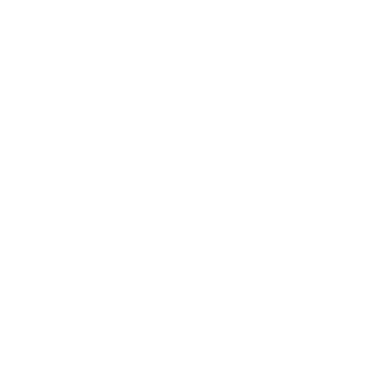

In [13]:
images = torch.tensor(cifar_10.data[:32])
plt.axis("off")
plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

In [4]:
# Define the transformation pipeline for the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# Load the CIFAR-10 training, validation and test datasets
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dataset = Subset(dataset, range(0, 45000))
val_dataset = Subset(dataset, range(45000, 50000))
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

print(f"\nSize of training dataset: {len(train_dataset)}")
print(f"Size of validation dataset: {len(val_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified

Size of training dataset: 45000
Size of validation dataset: 5000
Size of test dataset: 10000


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Training

The training loop is similar to what we did in the previous tutorial, with the following additions:
- We are using an ADAM optimizer. The difference with respect to SGD is that it does not use a static learning rate, but computes it dynamically based on estimates of the first as second moments. Intuitively, it takes into account how fast the gradients are changing to adapt the learning rate accordingly.
- At the end of each training epoch, we evaluate the model on:
    - The training dataset (exclusively for didactic purposes).
    - The validation dataset (to keep track of the best model along epochs).
    
Also, we define the function `visualize_training` to compare the evolution of the training and validation accuracies during the training.

In [7]:
def evaluate(model, dataloader):
    """
    Evaluate the model on the given dataloader.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataloader (torch.utils.data.DataLoader): DataLoader containing the evaluation dataset.

    Returns:
        float: The accuracy of the model on the evaluation dataset.
    """
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted_labels = torch.argmax(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()

    return correct / total


def train(model, train_dataloader, val_dataloader, n_epochs=50, lr=0.001, weight_decay=0.0001, compute_training_acc=True, verbose=False):
    """
    Train the given model.

    Args:
        model (torch.nn.Module): The model to train.
        train_dataloader (torch.utils.data.DataLoader): DataLoader containing the training dataset.
        val_dataloader (torch.utils.data.DataLoader): DataLoader containing the validation dataset.
        n_epochs (int, optional): Number of epochs for training. Default is 50.
        lr (float, optional): Learning rate for training. Default is 0.001.
        weight_decay(float, optional): L2 regularization parameter
        compute_training_acc(bool, optional): Flag to compute training accuracy every epoch.
        print_batch_loss(bool, optional): Flag to print loss evolution inside batches.

    Returns:
        tuple: A tuple containing the best model, training losses, training accuracies, and validation accuracies.
    """
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    max_val_acc = 0
    best_model = None

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(n_epochs):
        epoch_losses = []
        model.train()
        
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            
            if verbose and i % 100 == 0:
                print(f"Epoch {epoch} | Batch {i}/{len(train_dataloader)} | Training loss: {'{0:.4f}'.format(loss.item())}")
                  
        train_loss = np.mean(epoch_losses).item()
        train_losses.append(train_loss)

        val_acc = evaluate(model, val_dataloader)
        val_accuracies.append(val_acc)

        if (val_acc > max_val_acc):
            max_val_acc = val_acc
            best_model = copy.deepcopy(model)

        if compute_training_acc:
            train_acc = evaluate(model, train_dataloader)
            train_accuracies.append(train_acc)
            print(f"Epoch {epoch} | Training loss: {'{0:.4f}'.format(train_loss)} | Training accuracy: {'{0:.4f}'.format(train_acc)} | Validation accuracy: {'{0:.4f}'.format(val_acc)}")

        else: 
            print(f"Epoch {epoch} | Training loss: {'{0:.4f}'.format(train_loss)} | Validation accuracy: {'{0:.4f}'.format(val_acc)}")
    
    return best_model, train_losses, train_accuracies, val_accuracies


def visualize_training(train_accuracies, val_accuracies):
    """
    Visualize the training process.

    Args:
        train_accuracies (list): List of training accuracies.
        val_accuracies (list): List of validation accuracies.
    """
    plt.title("Training evolution")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().set_ylim(0, 1)
    epochs = range(1, len(train_accuracies) + 1)
    plt.plot(epochs, train_accuracies, label="Training")
    plt.plot(epochs, val_accuracies, label="Validation")
    plt.legend(loc="lower right")
    plt.show()

## 2. Using a simple CNN

We define a simple CNN model to classify this data into the 10 different classes:

In [8]:
class ConvNet(nn.Module):
    def __init__(self, n_classes):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv2D with 32 filters of size 3x3
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling2D with pool size 2x2
            nn.Conv2d(32, 64, kernel_size=5),  # Conv2D with 64 filters of size 5x5
            nn.ReLU(),  # ReLU activation
            nn.MaxPool2d(kernel_size=3, stride=3),  # MaxPooling2D with pool size 3x3
            nn.Conv2d(64, 64, kernel_size=3),  # Conv2D with 64 filters of size 3x3
            nn.ReLU()  # ReLU activation
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten layer
            nn.Linear(64 * 2 * 2, 64),  # Fully connected layer with 64 neurons
            nn.ReLU(),  # ReLU activation
            nn.Linear(64, n_classes)  # Output layer with 10 neurons (for classification)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

Now, we train the model using our `train` function.

In [9]:
set_seed(42) # Seed for reproducibility of the results
model = ConvNet(n_classes=10)
model = model.to(device)
model_simplenet, train_losses, train_accuracies, val_accuracies = train(model, train_dataloader, val_dataloader)

Epoch 0 | Training loss: 1.5863 | Training accuracy: 0.5050 | Validation accuracy: 0.5052
Epoch 1 | Training loss: 1.2678 | Training accuracy: 0.5865 | Validation accuracy: 0.5876
Epoch 2 | Training loss: 1.1085 | Training accuracy: 0.6411 | Validation accuracy: 0.6292
Epoch 3 | Training loss: 0.9957 | Training accuracy: 0.6867 | Validation accuracy: 0.6694
Epoch 4 | Training loss: 0.9088 | Training accuracy: 0.6932 | Validation accuracy: 0.6658
Epoch 5 | Training loss: 0.8440 | Training accuracy: 0.7282 | Validation accuracy: 0.6900
Epoch 6 | Training loss: 0.7869 | Training accuracy: 0.7183 | Validation accuracy: 0.6754
Epoch 7 | Training loss: 0.7421 | Training accuracy: 0.7674 | Validation accuracy: 0.7136
Epoch 8 | Training loss: 0.6953 | Training accuracy: 0.7710 | Validation accuracy: 0.7152
Epoch 9 | Training loss: 0.6614 | Training accuracy: 0.7858 | Validation accuracy: 0.7176
Epoch 10 | Training loss: 0.6239 | Training accuracy: 0.7987 | Validation accuracy: 0.7316
Epoch 11 

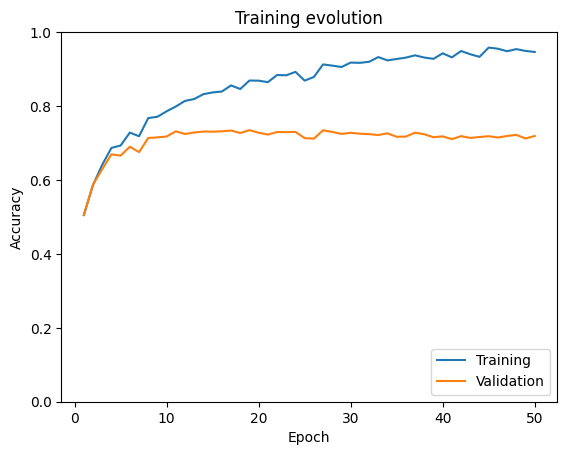

In [10]:
visualize_training(train_accuracies, val_accuracies)

In [ ]:
print("Test accuracy: " + str(evaluate(model_simplenet, test_dataloader)))

We observe that the model achieves a validation accuracy of 72% in 10 epochs. Beyond that, the training accuracy continues increasing, reaching almost perfect performance, but the validation accuracy stays constant with some fluctuations. This is an indicator of **overfitting**: the model is learning the training data very well, but it is not able to generalize to other data samples.

## 3. Data Augmentation

Data augmentation is a technique used to artificially increase the size and diversity of a training dataset. In the particular case of image classification, we can achieve this by applying transformations to the available images, such as rotating, flipping, cropping... This helps the classifier generalize better on data outside the training dataset, reducing overfitting.

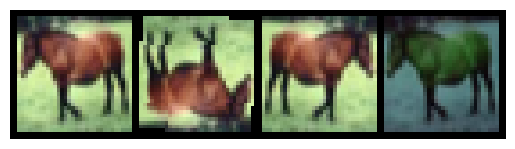

In [40]:
image = cifar_10[7][0]
rotator = transforms.RandomRotation(degrees=(0,180))
flipper = transforms.RandomHorizontalFlip(p=1)
color_jitter = transforms.ColorJitter(brightness=.5, hue=.3)

# Visualize augmented images
plt.axis("off")
plt.imshow(make_grid([image, rotator(image), flipper(image), color_jitter(image)], nrow=4).permute(1, 2, 0))

In this case, for example, using augmentations of that horse will allow the model to identify horses not only if they are similar to the training images, but also if they appear in different positions or under different light conditions.

Let's add some augmentations to our training dataset. For that purpose, we need to include the augmentations in the `transform` pipeline:

In [11]:
# Define new transformation pipeline for the training dataset, including augmentations
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [12]:
# Redefine training dataset and dataloader
train_dataset_augmented = Subset(torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_augmented), range(0, 45000))
train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)

Files already downloaded and verified


Let's train the model using the augmented dataset.

In [13]:
set_seed(42) # Seed for reproducibility of the results
model = ConvNet(n_classes=10)
model = model.to(device)
model_simplenet_augmented, train_losses, train_accuracies, val_accuracies = train(model, train_dataloader_augmented, val_dataloader)

Epoch 0 | Training loss: 1.6935 | Training accuracy: 0.4552 | Validation accuracy: 0.4910
Epoch 1 | Training loss: 1.3794 | Training accuracy: 0.5197 | Validation accuracy: 0.5454
Epoch 2 | Training loss: 1.2332 | Training accuracy: 0.5795 | Validation accuracy: 0.6102
Epoch 3 | Training loss: 1.1406 | Training accuracy: 0.6158 | Validation accuracy: 0.6428
Epoch 4 | Training loss: 1.0649 | Training accuracy: 0.6358 | Validation accuracy: 0.6632
Epoch 5 | Training loss: 1.0160 | Training accuracy: 0.6345 | Validation accuracy: 0.6714
Epoch 6 | Training loss: 0.9692 | Training accuracy: 0.6736 | Validation accuracy: 0.7002
Epoch 7 | Training loss: 0.9282 | Training accuracy: 0.6875 | Validation accuracy: 0.7104
Epoch 8 | Training loss: 0.8882 | Training accuracy: 0.7051 | Validation accuracy: 0.7204
Epoch 9 | Training loss: 0.8696 | Training accuracy: 0.6946 | Validation accuracy: 0.7138
Epoch 10 | Training loss: 0.8457 | Training accuracy: 0.6989 | Validation accuracy: 0.7072
Epoch 11 

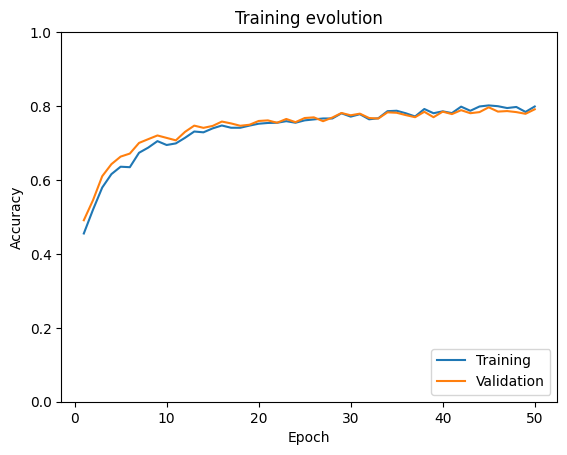

In [14]:
visualize_training(train_accuracies, val_accuracies)

In [15]:
print("Test accuracy for agumented model: " + str(evaluate(model_simplenet_augmented, test_dataloader)))

Test accuracy for agumented model: 0.7844


We observe how, in this case, both training and validation accuracies evolve in a similar way, getting a higher accuracy in the validation and test datasets than in the previous experiment.

Feel free to experiment with more augmentation techniques, like random fips or crops. You can check more examples of augmentations in PyTorch [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py). Which augmentation types lead to the highest increase in performance for this dataset?

Also, try to reflect on how we have implemented data augmentation by answering the following questions:
- Inside a batch, we do not preserve the original version of the augmented images. In other words, augmented images are not copies of the original images, but we are just modifying the original images themselves. Why is this not a problem?
- Why are we adding augmentations only to the training dataset?

## 3. Transfer learning

Another way of improving performance is using a more complex architecture. Nevertheless, we probably do not have the computational resources needed to train such complex models. 

An alternative to palliate this issue is, instead of training a whole model form scratch, taking advantage of an already pretrained model. Obviously, we cannot use a model that has been trained on a different dataset in an _off-the-shelf_ manner, but the features captured by the intermediate layers can be leveraged for our taks.

We will use [VGG19](https://arxiv.org/abs/1409.1556), a deep convolutional model trained on images of 1000 different classes from the [ImageNet](https://www.image-net.org/index.php) dataset.

First, let's load the model and analyze its architecture:

In [ ]:
model_vgg19 = models.vgg19(pretrained=True)
model_vgg19

The architecture is divided in two main modules:

- `features`: convolutional module that extracts features from the images. We will freeze this part, i.e. the parameters of these layers will not be modified in the optimization step.

- `classifier`: linear module that maps the features to the logits for each of the 1000 classes of the original model. We will change the linear layers of this module to adapt it to our output size (10, which is the number of classes in CIFAR10).

_Question for the reader: what does the "19" on the model name stand for?._

The following code cell freezes/redefines the above mentioned modules:

In [17]:
# Freeze all parameters:
for param in model_vgg19.parameters():
    param.requires_grad = False

# Redefine linear layers in the classifier module (by redefining them, requires grad will be set to True by default)
model_vgg19.classifier[3] = nn.Linear(4096, 512)
model_vgg19.classifier[6] = nn.Linear(512, 10)

We also need to redefine the datasets and dataloaders, so that the images have the same size and follow the same distribution as the ones that were used to train the original model:

In [18]:
# Define new transform function
transform_vgg19 = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Redefine datasets
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_vgg19)
train_dataset = Subset(dataset, range(0, 45000))
val_dataset = Subset(dataset, range(45000, 50000))
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_vgg19)

# Redefine dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Let's train the model! For this example, we will train it for only five epochs, and we will not compute accuracy on the training set to save computation time. If it's too slow for you, you can also run it for fewer epochs by changing the `n_epochs` argument of the `train` function.

In [20]:
model_vgg19 = model_vgg19.to(device)
model_vgg19, train_losses, train_accuracies, val_accuracies = train(model_vgg19, train_dataloader, val_dataloader, n_epochs=5, lr=0.0001, weight_decay=0.00001, compute_training_acc=False, verbose=True)

Epoch 0 | Batch 0/704 | Training loss: 2.3337


KeyboardInterrupt: 

In [ ]:
print("Test accuracy for refined vgg19: " + str(evaluate(model_vgg19, test_dataloader)))

Test accuracy for refined vgg19: 0.8316


With only a few training epoch, we are already outperforming our previous method. Training the model for more epochs or using more complex final layers can help us improve the test accuracy.